In [1]:
import numpy as np
import healpy as hp
import skyproj
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import astropy.coordinates
from astropy import units as u
from scipy import stats
import galstreams #contains stream data
%matplotlib inline

## define some plotting functions

In [2]:
def change_coord(m, coord):   
    """ Change coordinates of a HEALPIX mapc

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

 # from https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system

In [3]:
def plot_streams(sp, mws=None, dist=False, streamlist=None, annotate=False):
    """ Plots streams from the galstreams package.

    Parameters
    ----------
    sp : skyproj object
      map on which to plot the streams
    mws : galstreams MWStreams instance of the stream catalog
      catalog of streams to plot (see galstreams documentation)
      if not provided, loads it (pre-loading speeds up loops) 
      and deletes it afterward (saves memory)
    dist : boolean
      whether to plot the streams colored and labeled individually (False) 
      or using a common color scale proportional to their heliocentric distance (True)
    streamlist : list of strings
      which streams to plot from the catalog. if None, plots all of them
    annotate : boolean
      whether to label each stream with its number in the catalog
      (for easier identification)
      
    Returns
    -------
    cbh : figure handle containing information needed to produce a colorbar 
    
    Example
    -------
    Plot all the streams; load the stream catalog in situ 
    >>>> plot_streams(sp)
    Plot a list of streams from a pre-loaded catalog, colored by distance and labeled
    >>>> # load the catalog:
    >>>> mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)
    >>>> # select streams near the south pole
    >>>> s_pole = mws.get_track_names_in_sky_window([0,359]*u.deg, [-90,-30]*u.deg, frame=astropy.coordinates.Galactic)
    >>>> # plot in a pre-defined skyproj
    >>>> plot_streams(sp, mws, distance=True, streamlist=s_pole, annotate=True)
    """
    if mws is None:
        mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)
        cleanup = True
    else: cleanup = False
    if streamlist is None: streamlist = mws.keys()
    cbh=None
    for st in streamlist:
        if dist:
            cmap = plt.get_cmap('magma')
            norm = matplotlib.colors.LogNorm(vmin=5.0,vmax=60.)
      #Plot the tracks of streams with distances in color, otherwise gray
            if mws.summary.has_D[st]==1:
                cbh = sp.scatter(mws[st].track.galactic.l.wrap_at(180*u.deg).value, 
                 mws[st].track.galactic.b.value, c=mws[st].track.distance,
                                 alpha=0.75, s=10, marker='.', cmap=cmap, norm=norm,
                 label="{ID:.0f}={Name}".format(ID=mws[st].ID,Name=mws[st].stream_name))
            else: #streams whose distances have not been measured are plotted in gray
                sp.scatter(mws[st].track.galactic.l.wrap_at(180*u.deg).value, 
                 mws[st].track.galactic.b.value, c='gray', alpha=0.75, s=10, marker='.', 
             label="{ID:.0f}={Name}".format(ID=mws[st].ID,Name=mws[st].stream_name))
        else: #plot streams in alternating colors
            sp.scatter(mws[st].track.galactic.l.wrap_at(180*u.deg).value, 
                 mws[st].track.galactic.b.value, alpha=0.75, s=10, marker='.', 
             label="{ID:.0f}={Name}".format(ID=mws[st].ID,Name=mws[st].stream_name))
        if annotate:
            xo = mws[st].end_points.galactic.l.wrap_at(180*u.deg)[0].value
            yo = mws[st].end_points.galactic.b[0].value
            ext = sp.get_extent()
            lmin,lmax,bmin,bmax = min(ext[:2]), max(ext[:2]), min(ext[2:]), max(ext[2:])
            if xo<lmin or xo>lmax or yo<bmin or yo>bmax:
                xo = mws[st].end_points.galactic.l.wrap_at(180*u.deg)[1].value
                yo = mws[st].end_points.galactic.b[1].value
            sp.ax.text(xo,yo,mws[st].ID)
    if cleanup:
        del(mws)
    return cbh

In [4]:
#plots the nearby galaxies (requires nbg.cat list of galaxies)

def plot_galaxies(sp, glist=None, annotate=False, glabels=None):
    """ plots all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)

    Parameters
    ----------
    sp : skyproj object
      map on which to plot the galaxies
    glist: list of integers
      list of indices for galaxies to label
      if None, plots the whole table
    glabels: list of strings
      labels for the galaxies
      if None, numbers them 1 to N
    Returns
    -------
    cbh : figure handle containing information needed to produce a colorbar 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """

    import pandas as pd
    #read and process the table
    nbg=pd.read_csv('../data/nbg.cat',sep="|",usecols=range(1,13))
    ras=[]
    decs=[]
    hms_str = ['h','m','s']
    dms_str = ['d','m','s']
    for i in range(len(nbg)):
        ra_str=nbg['RA J2000  '][i].split(' ')
        dec_str = nbg['DEC J2000'][i].split(' ')
        ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
        decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
    nbgs= astropy.coordinates.SkyCoord(ras,decs)

    #set up the colormap (log distance)
    cmap = plt.get_cmap('cividis')
    norm = matplotlib.colors.LogNorm(vmin=0.02,vmax=10.)

    #plot the galaxies
    if glist is None:
        cbh = sp.scatter(nbgs.galactic.l.value, nbgs.galactic.b.value, c=nbg[' D (Mpc)'],  edgecolors= "black", cmap=cmap, norm=norm, s=40)

    else:
        cbh = sp.scatter(nbgs.galactic.l.value[glist], nbgs.galactic.b.value[glist], c=nbg[' D (Mpc)'][glist],  edgecolors= "black", cmap=cmap, norm=norm, s=40)
        #label the ones listed
        if annotate:
            if glabels is None:
                glabels = np.arange(1, len(glist)+1).astype('str')
            for i, l in enumerate(glabels):
                x,y = sp.proj(nbgs[glist[i]].galactic.l.deg, nbgs[glist[i]].galactic.b.deg)       
                r = 100
                costh = 2 * np.random.rand() - 1
                sgn = np.sign(2 * np.random.rand() - 1)
                xt, yt = r*costh, r*sgn*np.sqrt(1-costh*costh)
                sp.ax.annotate(l, (x,y), (xt,yt),textcoords='offset points',arrowprops=dict(arrowstyle='-',color='k'),va='top',ha='left')
        
    return cbh

In [5]:
def read_galaxies():
    """ reads list of all galaxies within 10 Mpc 
    (requires nbg.cat--- file with table of galaxies from Karachentsev et al)
      
    Returns
    -------
    nbg : pandas dataframe with table in it
    nbgs : list of skycoords for each galaxy 
    
    Example
    -------
    Plot all the galaxies on a predefined skyproj
    >>>> plot_galaxies(sp)
    """

    import pandas as pd
    #read and process the table
    nbg=pd.read_csv('../data/nbg.cat',sep="|",usecols=range(1,13))
    ras=[]
    decs=[]
    hms_str = ['h','m','s']
    dms_str = ['d','m','s']
    for i in range(len(nbg)):
        ra_str=nbg['RA J2000  '][i].split(' ')
        dec_str = nbg['DEC J2000'][i].split(' ')
        ras.append("".join(x+y for x,y in zip(ra_str,hms_str)))
        decs.append("".join(x+y for x,y in zip(dec_str,dms_str)))
    nbgs= astropy.coordinates.SkyCoord(ras,decs)

    return nbg, nbgs

In [6]:
def read_gcs():
    """ reads globular clusters from Vasiliev & Baumgardt 2021

    Returns
    -------
    gcs : table of GC data 
    
    """

    #download catalog
    from astroquery.vizier import Vizier
    vizier = Vizier() 
    CATALOGUE = "J/MNRAS/505/5978/tablea1"
    vizier.ROW_LIMIT = -1
    gcs = vizier.get_catalogs(CATALOGUE)[0]

    return gcs

In [7]:
def plot_gcs(sp,gcs=None,gclist=None,annotate=False):
    """ plots globular clusters from Vasiliev & Baumgardt 2021

    Parameters
    ----------
    sp : skyproj object
      map on which to plot the galaxies
    gcs : astropy table
      table of GC data
    gclist : list or array of integers
      list of indices into gcs for clusters to plot
    annotate : boolean
      whether or not to annotate clusters with names
      
    Returns
    -------
    cbh : figure handle containing information needed to produce a colorbar 
    
    Example
    -------
    Plot all the GCs on a predefined skyproj
    >>>> plot_gcs(sp)
    """

    #download catalog
    if gcs is None:
        gcs = read_gcs()

    if gclist is not None:
        gcs = gcs[gclist]
        
    #extract sky coordinates
    gcradec = astropy.coordinates.SkyCoord(gcs['RAJ2000'],gcs['DEJ2000'])
    #set up the colormap (log distance)
    cmap = plt.get_cmap('plasma')
    norm = matplotlib.colors.LogNorm(vmin=1.0,vmax=100.)

    dists = 1./gcs["plx"]*u.kpc

    nodist = (dists<0) #negative parallaxes !
    #plot stuff without a good distance in gray
    sp.scatter(gcradec[nodist].galactic.l.value, gcradec[nodist].galactic.b.value, c='gray',  edgecolors= "black", s=20)
    #plot the globular clusters
    cbh = sp.scatter(gcradec[~nodist].galactic.l.value, gcradec[~nodist].galactic.b.value, c=dists[~nodist],  edgecolors= "black", cmap=cmap, norm=norm, s=20)

    if annotate:
        for i,l in enumerate(gcs['Name']):
            x,y = sp.proj(gcradec[i].galactic.l.deg, gcradec[i].galactic.b.deg)       
            r = 30
            costh = 2 * np.random.rand() - 1
            xt, yt = r*costh, r*np.sqrt(1-costh*costh)
            sp.ax.annotate(l, (x,y), (xt,yt),textcoords='offset points',arrowprops=dict(arrowstyle='-',color='k'),va='top',ha='left')

    return cbh

## set up different datasets

In [8]:
# read in healpix Gaia map
filename = '../data/gaia_stellar_density_map_G_21_gal_nside_128_v0.fits'
gaiamap = hp.read_map(filename)
#gaiamap = change_coord(gaiamap, ['G', 'C'])
gaiamap -= np.min(gaiamap)
scale = np.std(gaiamap)*0.2
print(scale)
scaled_gmap = np.asinh(gaiamap/scale)
stats.describe(scaled_gmap)

3871.5254


DescribeResult(nobs=196608, minmax=(np.float32(0.0), np.float32(4.782536)), mean=np.float32(0.8090007), variance=np.float64(0.9290710854967015), skewness=np.float64(1.5884634256362915), kurtosis=np.float32(1.9741592))

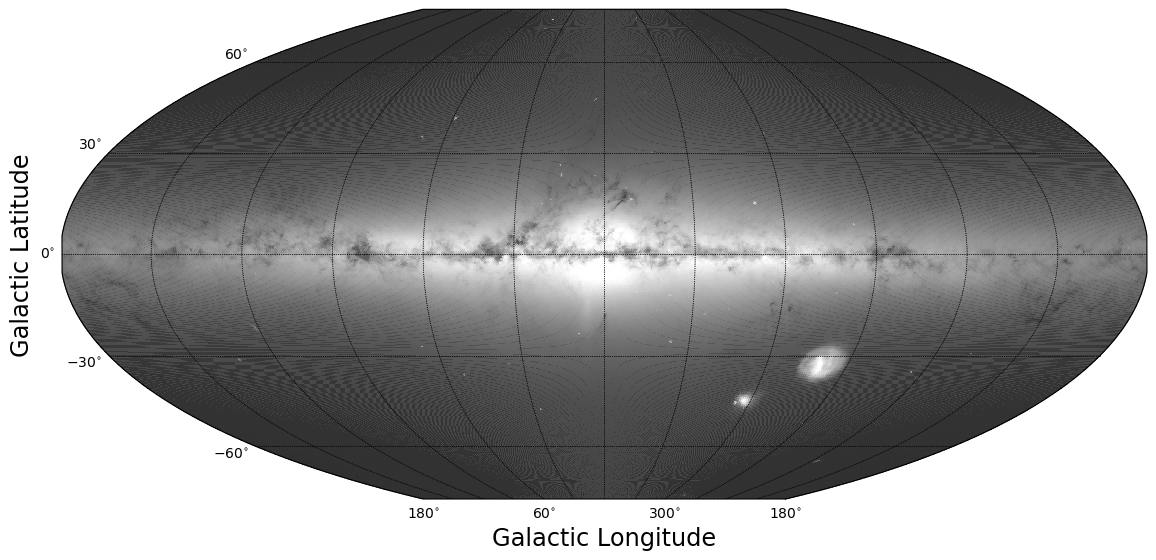

In [72]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90],  galactic=True)
sp.draw_hpxmap(scaled_gmap,alpha=0.9,cmap='gray',vmin=-1.0,vmax=4.5)
plt.show()

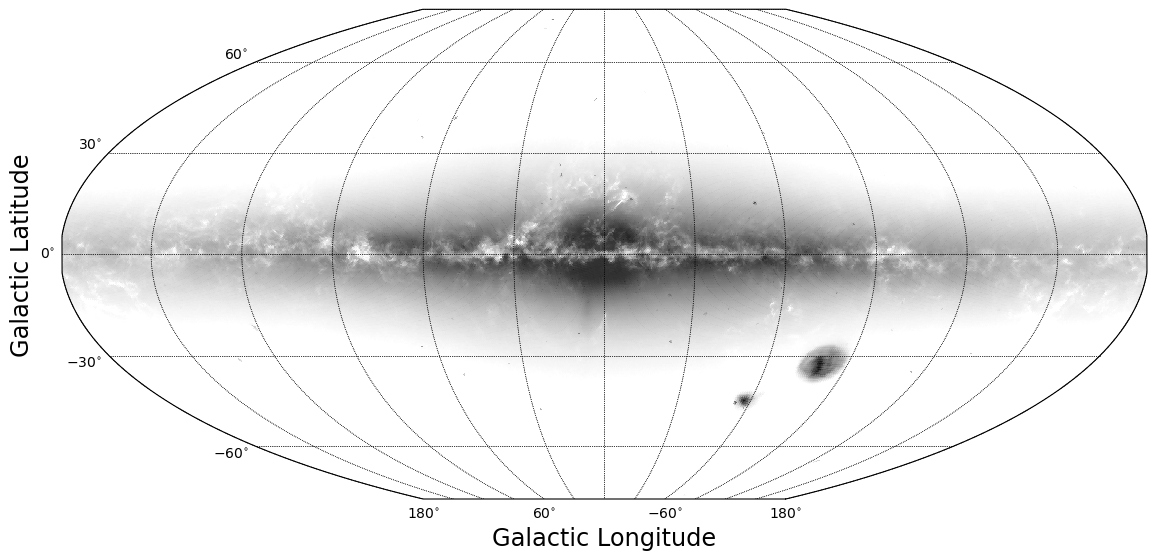

In [73]:
fig = plt.figure(1, figsize=(14, 10))
ax = fig.add_subplot(111)
sp = skyproj.sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90],  longitude_ticks='symmetric',galactic=True)
sp.draw_hpxmap(scaled_gmap,alpha=0.9,cmap='gray_r',vmin=0.5,vmax=5.0)
plt.show()

In [9]:
# Read maps with the "tiles" covered -- these are built from APT's outputs
HLWAS_wide = hp.read_map('../data/HLWAS_WIDE_0328_APT994_1024.fits.gz')
HLWAS_medium = hp.read_map('../data/HLWAS_MEDIUM_0328_APT994_1024.fits.gz')
GPS = hp.read_map('../data/GPS_ALL_0328_1024.fits.gz')
maps = [HLWAS_wide, HLWAS_medium, GPS]

In [10]:
# Combine all maps -- HLWAS Wide = 1, HLWAS medium = 2, GPS = 3
debug = False
combined_map = np.zeros_like(HLWAS_wide)
for i, m in enumerate(maps):
    m[m==hp.UNSEEN] = 0.
    combined_map[m!=0] = (i+1)*1.0
    if debug:
        hp.mollview(combined_map, coord=['C','G'])

In [11]:
combined_map[combined_map <=0] = hp.UNSEEN # Fill back with UNSEEN
combined_map = change_coord(combined_map,['C','G'])

In [12]:
# Create a custom colorbar for the 3 maps
from matplotlib.colors import ListedColormap
import matplotlib
# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict = {1: "palegreen", # "lightskyblue",
            2: "limegreen", # "dodgerblue",
            3: "firebrick"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM", "GPS"])
len_lab = len(labels)

In [13]:
# Add coordinates for GTBDS and HLTDS
gbtds_one = astropy.coordinates.SkyCoord('17h50m16.8700s', '-28d41m11.10s')
gbtds_two = astropy.coordinates.SkyCoord('17h49m53.4700s','-28d49m31.00s')
elais_n1 = astropy.coordinates.SkyCoord('16h10m1.0000s', '+54d30m36.00s')
euclid_s_wide = astropy.coordinates.SkyCoord('04h14m24.0000s', '-47d36m0.00s')
euclid_s_deep = astropy.coordinates.SkyCoord('03h55m36.0000s', '-49d19m12.00s')
hlwas_cosmos = astropy.coordinates.SkyCoord('10h00m24.0000s', '+02d10m55.00s')
hlwas_xmm = astropy.coordinates.SkyCoord('02h22m50.0000s', '-04d45m0.00s')

In [14]:
#read the stream catalog
mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)

Initializing galstreams library from master_log... 


## all-sky figure in Galactic coordinates, with streams superimposed by distance

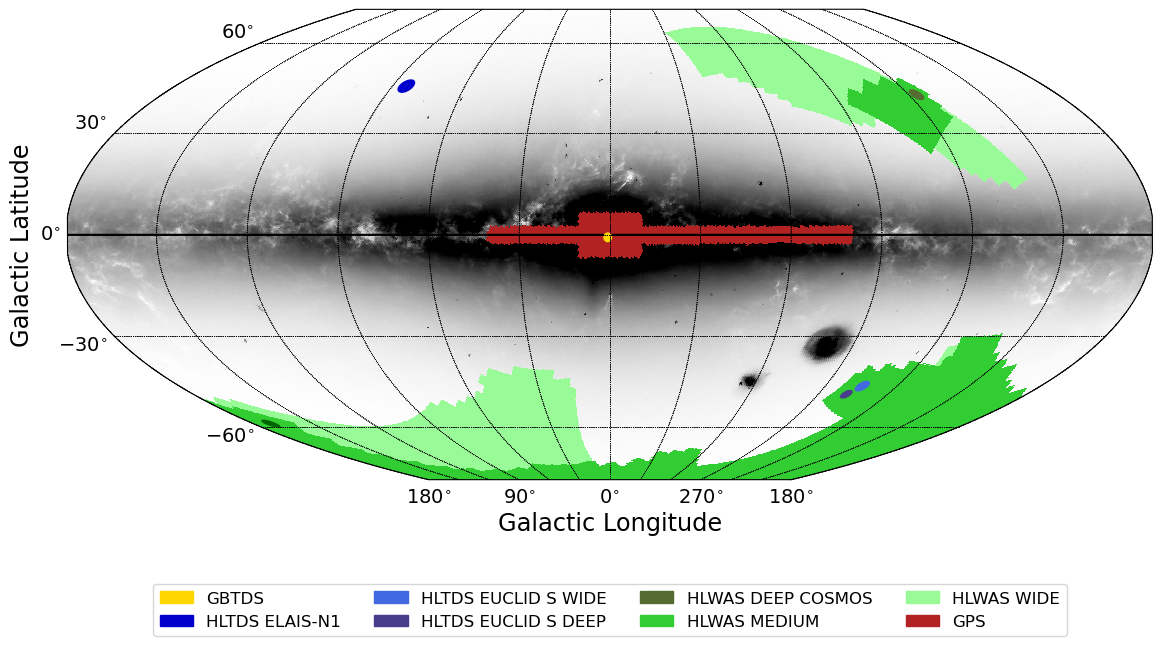

In [87]:
fig = plt.figure(1, figsize=(14, 11))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90], galactic=True, min_lon_ticklabel_delta=0.06)

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0)

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

sp.draw_milky_way(width=0,zorder=1)
patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
sp.circle(gbtds_one.galactic.l.value, gbtds_one.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)


#plot stream tracks

#cbh = plot_streams(sp, mws, dist=True)


#make legend
handles, labels = sp.ax.get_legend_handles_labels()
#handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
shandles = handles[0:5]
shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
shandles.extend([patch_GPS])
#shandles.extend(handles[5:])


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
#plt.colorbar(cbh,label='Distance (kpc)', shrink=0.5)
#plt.savefig('../figures/ccs_footprints_streams.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_galactic.png',dpi=300,bbox_inches='tight')
plt.show()

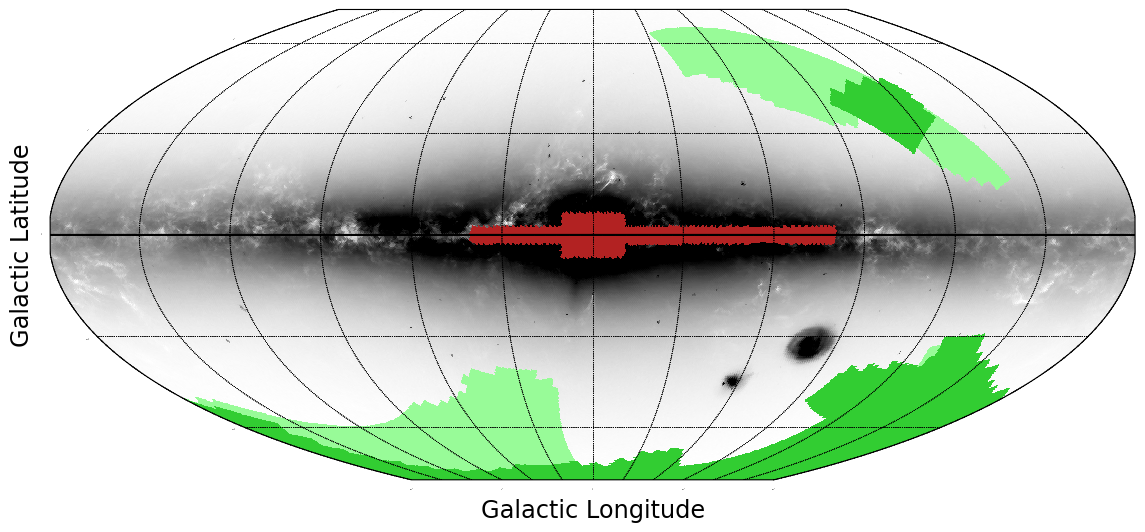

In [96]:
fig = plt.figure(1, figsize=(14, 11))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90], galactic=True, min_lon_ticklabel_delta=0.06)

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0)

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

sp.draw_milky_way(width=0,zorder=1)
patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
# patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
# sp.circle(gbtds_one.galactic.l.value, gbtds_one.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
# #HLTDS
# sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
# sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
# sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
# #HLWAS DEEP
# sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
# sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)


#plot stream tracks

#cbh = plot_streams(sp, mws, dist=True)


#make legend
# handles, labels = sp.ax.get_legend_handles_labels()
# #handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
# shandles = handles[0:5]
# shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
# shandles.extend([patch_GPS])
# #shandles.extend(handles[5:])


# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=0)
sp.ax.tick_params(axis="y", labelsize=0)
#plt.colorbar(cbh,label='Distance (kpc)', shrink=0.5)
#plt.savefig('../figures/ccs_footprints_streams.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/hlwas_footprint_galactic_nolabel.png',dpi=300,bbox_inches='tight')
plt.show()

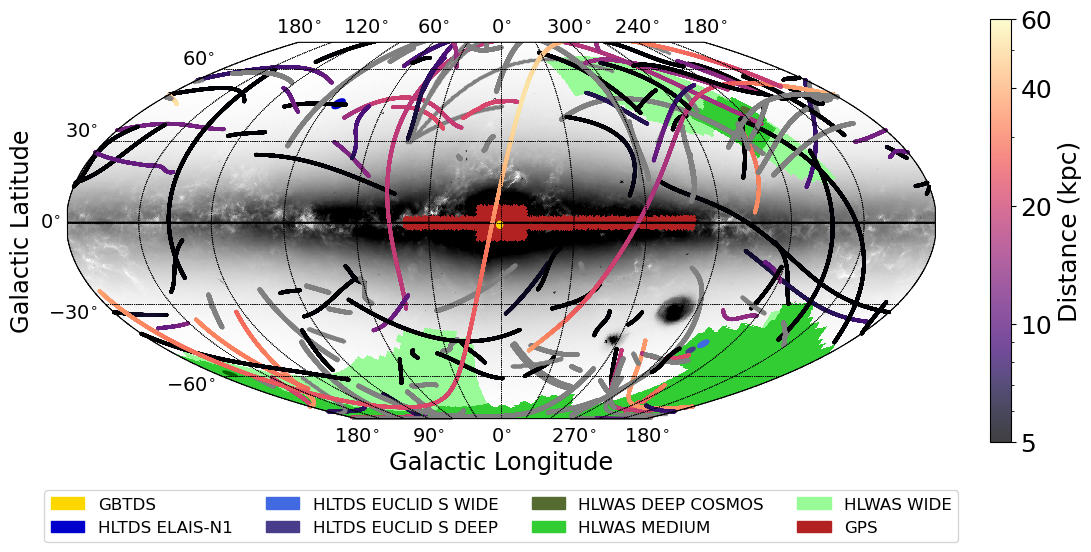

In [86]:
fig = plt.figure(1, figsize=(14, 11))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90], galactic=True, min_lon_ticklabel_delta=0.06)

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0)

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

sp.draw_milky_way(width=0,zorder=1)
patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
sp.circle(gbtds_one.galactic.l.value, gbtds_one.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)


#plot stream tracks

cbh = plot_streams(sp, mws, dist=True)


#make legend
handles, labels = sp.ax.get_legend_handles_labels()
#handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
shandles = handles[0:5]
shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
shandles.extend([patch_GPS])
#shandles.extend(handles[5:])


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
cb=plt.colorbar(cbh,shrink=0.5)
cb.ax.tick_params(labelsize=18)
cb.ax.set_ylabel('Distance (kpc)', fontsize=18)
cb.ax.set_yticks([5,10,20,40,60])
cb.ax.set_yticklabels([5,10,20,40,60])
#plt.savefig('../figures/ccs_footprints_streams.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_streams.png',dpi=300,bbox_inches='tight')
plt.show()

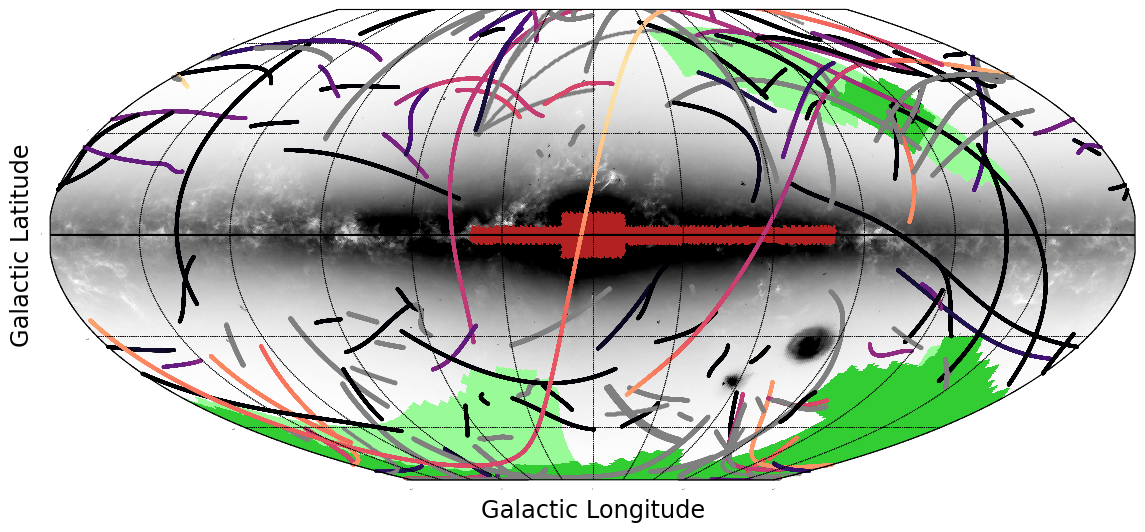

In [98]:
fig = plt.figure(1, figsize=(14, 11))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90], galactic=True, min_lon_ticklabel_delta=0.06)

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0)

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

sp.draw_milky_way(width=0,zorder=1)
patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
# patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
# sp.circle(gbtds_one.galactic.l.value, gbtds_one.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
# #HLTDS
# sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
# sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
# sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
# #HLWAS DEEP
# sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
# sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)


#plot stream tracks

cbh = plot_streams(sp, mws, dist=True)


#make legend
# handles, labels = sp.ax.get_legend_handles_labels()
# #handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
# shandles = handles[0:5]
# shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
# shandles.extend([patch_GPS])
#shandles.extend(handles[5:])


# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=0)
sp.ax.tick_params(axis="y", labelsize=0)
# cb=plt.colorbar(cbh,shrink=0.5)
# cb.ax.tick_params(labelsize=18)
# cb.ax.set_ylabel('Distance (kpc)', fontsize=18)
# cb.ax.set_yticks([5,10,20,40,60])
# cb.ax.set_yticklabels([5,10,20,40,60])
#plt.savefig('../figures/ccs_footprints_streams.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/hlwas_footprint_streams_nolabels.png',dpi=300,bbox_inches='tight')
plt.show()

## all-sky figure in Galactic coordinates with nearby galaxies plotted by distance

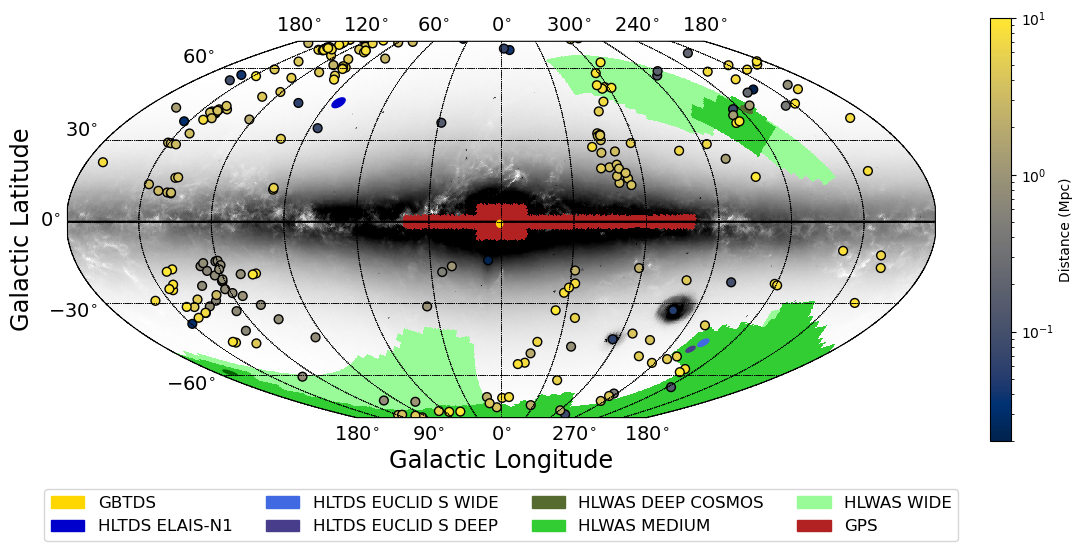

In [34]:
fig = plt.figure(1, figsize=(14, 11))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90], galactic=True, min_lon_ticklabel_delta=0.06)

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0)

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

sp.draw_milky_way(width=0,zorder=1)
patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
sp.circle(gbtds_one.galactic.l.value, gbtds_one.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)


#plot stream tracks

cbh = plot_galaxies(sp)


#make legend
handles, labels = sp.ax.get_legend_handles_labels()
#handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
shandles = handles[0:5]
shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
shandles.extend([patch_GPS])
#shandles.extend(handles[5:])


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
plt.colorbar(cbh,label='Distance (Mpc)', shrink=0.5)
plt.savefig('../figures/ccs_footprints_nbgs.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_nbgs.png',dpi=200,bbox_inches='tight')
plt.show()

## plot gcs all-sky

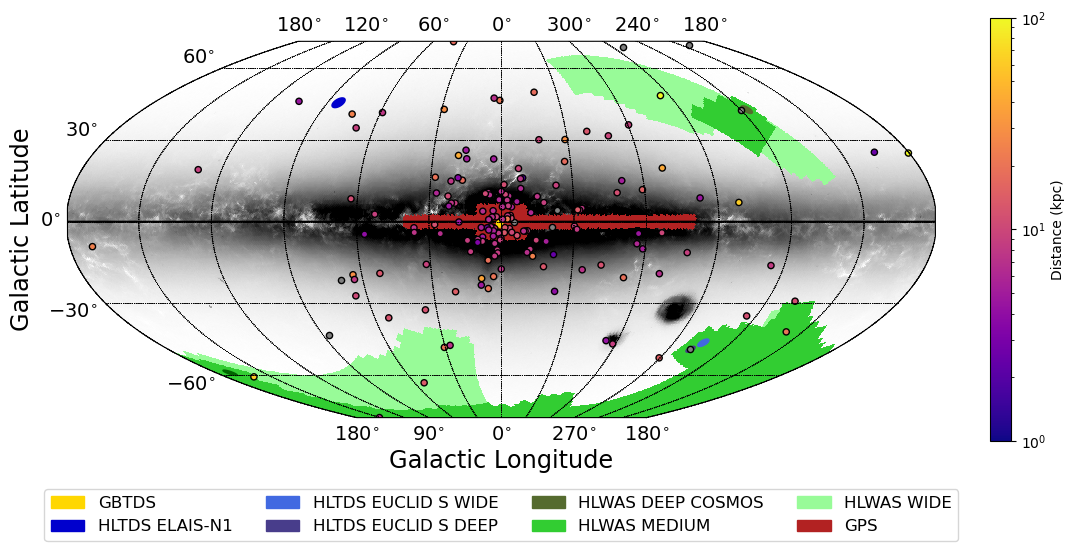

In [35]:
fig = plt.figure(1, figsize=(14, 11))
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax, extent=[-180,180, -90, 90], galactic=True, min_lon_ticklabel_delta=0.06)

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0)

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(-180,180), lat_range=(-90, 90), alpha=alph, vmin=1, vmax=3, cmap=cm)

sp.draw_milky_way(width=0,zorder=1)
patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
patch_GPS = mpatches.Patch(color=col_dict[3], label='GPS')

# Add circles for the other surveys -- the size of the circles are kind of proportional to their footprints but it's not the actual size
#GBTDS
sp.circle(gbtds_one.galactic.l.value, gbtds_one.galactic.b.value, 2.5/2, label='GBTDS', fill=True, alpha=alph, color='gold')
#HLTDS
sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)
#HLWAS DEEP
sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)

cbh=plot_gcs(sp)



#make legend
handles, labels = sp.ax.get_legend_handles_labels()
#handles.extend([patch_HLWAS_w, patch_HLWAS_m, patch_GPS])
shandles = handles[0:5]
shandles.extend([patch_HLWAS_m,patch_HLWAS_w])
shandles.extend([patch_GPS])
#shandles.extend(handles[5:])


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

sp.legend(handles=shandles, loc='lower center', ncol=4, bbox_to_anchor=(0, -0.35, 1.0, 0.55), fontsize=12)

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
plt.colorbar(cbh,label='Distance (kpc)', shrink=0.5)
plt.savefig('../figures/ccs_footprints_gcs.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_gcs.png',dpi=200,bbox_inches='tight')
plt.show()

## additional setup for polar projections (drop the regions in the galactic plane)

In [15]:
maps = [HLWAS_wide, HLWAS_medium]
combined_map = np.zeros_like(HLWAS_wide)
for i, m in enumerate(maps):
    m[m==hp.UNSEEN] = 0.
    combined_map[m!=0] = (i+1)*1.0
combined_map[combined_map <=0] = hp.UNSEEN # Fill back with UNSEEN
combined_map = change_coord(combined_map,['C','G'])

col_dict = {1: "palegreen", # "lightskyblue",
            2: "limegreen"}

# We create a colorbar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM"])
len_lab = len(labels)

In [16]:
ns = hp.get_nside(combined_map)

combined_map[hp.ang2pix(ns,euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value,lonlat=True)]

np.float64(2.0)

## plot north and south pole projections

### southern galactic cap with streams

In [17]:
id_in_hlwas = [99,60,90,96,95,93,8,78,90,36,72,3,64,108,29,125,54,79,4,26,24,110,126,137,30,67,68,125,25,118,67,66,69,122,29]
in_hlwas = []
for st in mws.keys():
    if mws[st].ID in id_in_hlwas:
        in_hlwas.append(st)

In [18]:
#select streams that cross the southern galactic cap
s_pole = mws.get_track_names_in_sky_window([0,359]*u.deg, [-90,-30]*u.deg, frame=astropy.coordinates.Galactic)


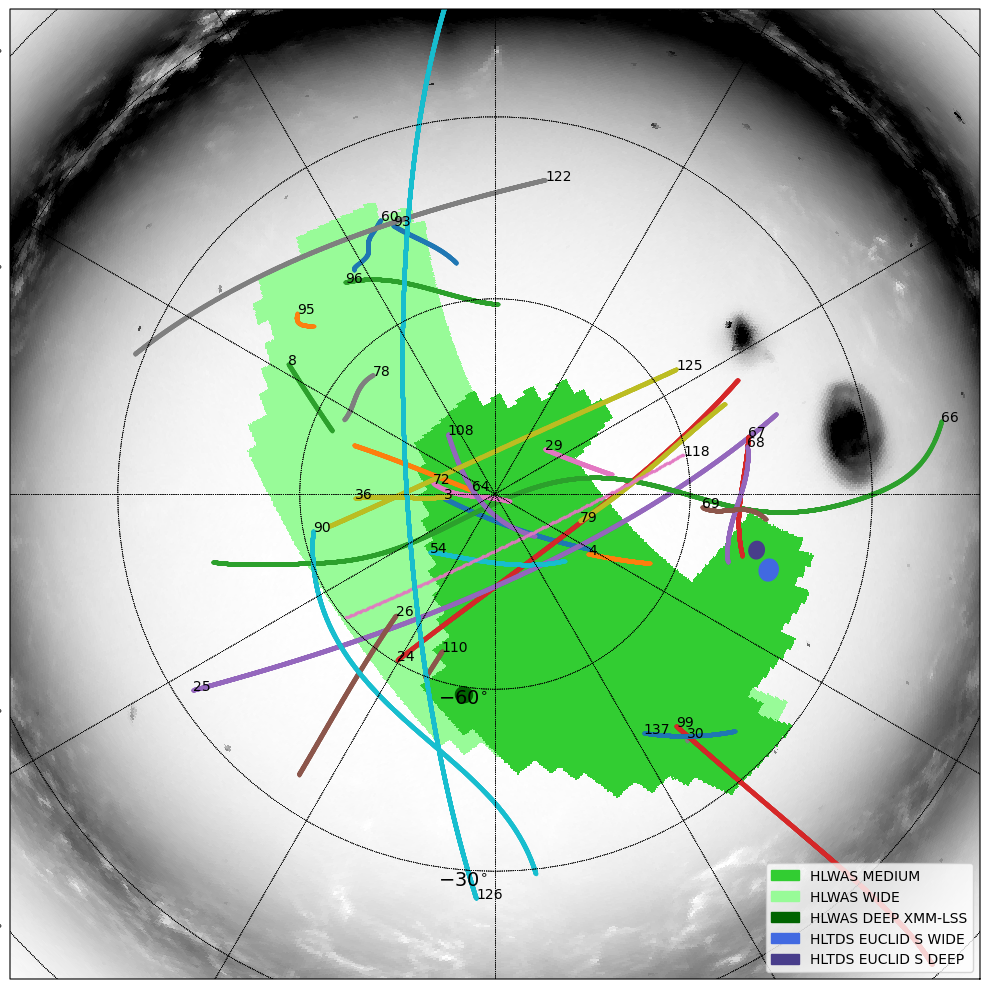

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(-90, -10))
im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
#sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
#sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')

plot_streams(sp,mws,dist=False, streamlist = in_hlwas, annotate=True)
#cbh = plot_galaxies(sp)

shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles[:3])

sp.legend(handles=shandles, loc='lower right', ncol=1,  fontsize=10)#, bbox_to_anchor=(1.0,0.0, 0.05, 1.0))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
plt.tight_layout()
#plt.colorbar(cbh,label='Distance (kpc)', shrink=0.5)
#plt.savefig('../figures/ccs_footprints_streams_southpole.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_streams_southpole.png',dpi=200,bbox_inches='tight')
#plt.show()

Streams colored by distance

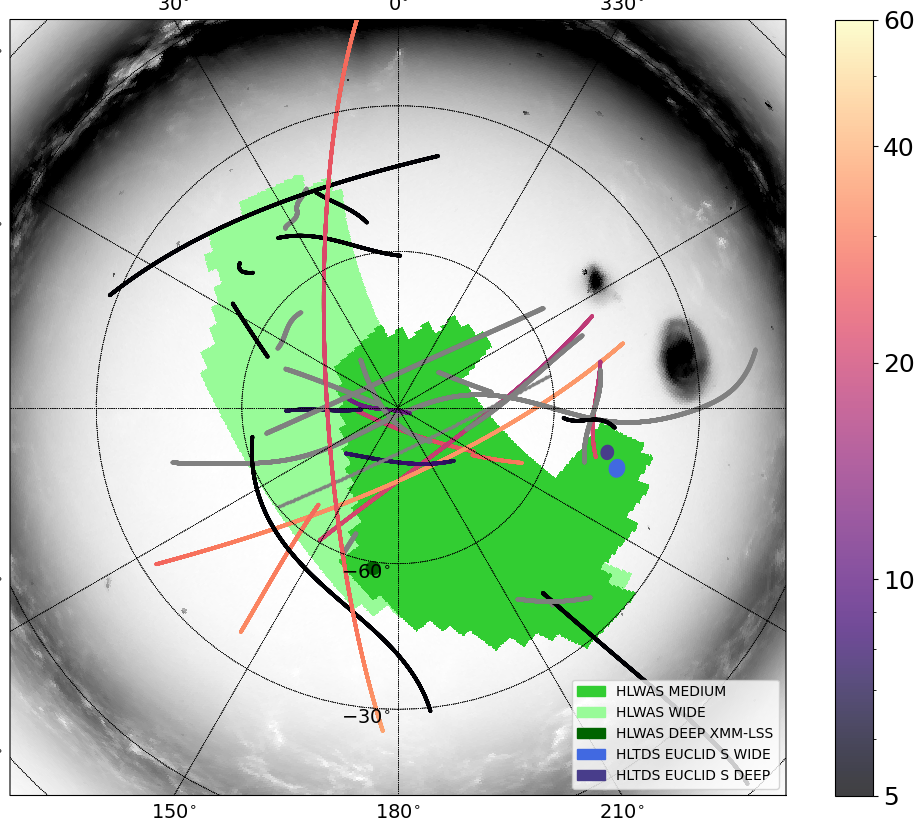

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(-90, -10))
im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
#sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
#sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')

cbh=plot_streams(sp,mws,dist=True, streamlist = in_hlwas, annotate=False)
#cbh = plot_galaxies(sp)

shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles[:3])

sp.legend(handles=shandles, loc='lower right', ncol=1,  fontsize=10)#, bbox_to_anchor=(1.0,0.0, 0.05, 1.0))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
plt.tight_layout()
cb = plt.colorbar(cbh,shrink=0.8)
cb.ax.tick_params(labelsize=18)
cb.ax.set_yticks([5,10,20,40,60])
cb.ax.set_yticklabels([5,10,20,40,60])
#cb.ax.set_ylabel('Distance (kpc)',fontsize=18,labelpad=0)
#plt.savefig('../figures/ccs_footprints_streams_southpole.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_streams_southpole_distances.png',dpi=300)
plt.show()

In [24]:
len(in_hlwas)

31

In [48]:
nbgs_in_hlwas_south[5:13]

[64, 65, 87, 101, 113, 115, 123, 147]

In [50]:
nbgs[147:148]

Gal. Name      RA J2000    DEC J2000  Bmag    Kmag   Maj. Diam (kpc)  \
147  DDO226         00 43 03.8  -22 15 01   14.9   12.48             3.12   

      D (Mpc)    HRV (km/s)     AbsBmag    angle    Maj_arcmin  Unnamed: 12  
147      4.92              359     -13.6  -84.7646        2.24          NaN

Streams with galaxies superimposed

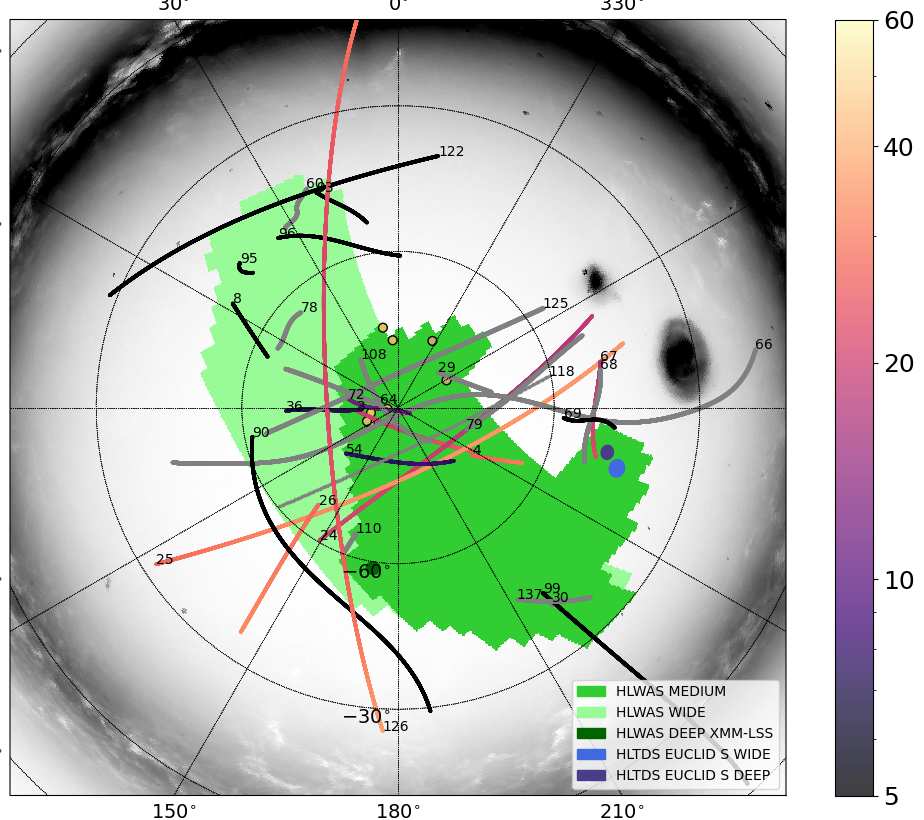

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(-90, -10))
im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
#sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
#sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')

plot_galaxies(sp,glist=nbgs_in_hlwas_south[5:13],annotate=False)
cbh=plot_streams(sp,mws,dist=True, streamlist = in_hlwas, annotate=True)


shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles[:3])

sp.legend(handles=shandles, loc='lower right', ncol=1,  fontsize=10)#, bbox_to_anchor=(1.0,0.0, 0.05, 1.0))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
plt.tight_layout()
cb = plt.colorbar(cbh,shrink=0.8)
cb.ax.tick_params(labelsize=18)
cb.ax.set_yticks([5,10,20,40,60])
cb.ax.set_yticklabels([5,10,20,40,60])
#cb.ax.set_ylabel('Distance (kpc)',fontsize=18,labelpad=0)
#plt.savefig('../figures/ccs_footprints_streams_southpole.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_streams_southpole_distances.png',dpi=300)
plt.show()

In [28]:
mws.summary.TrackRefsLatex[in_hlwas[0]]

'Li2021'

In [31]:
for st in in_hlwas:
    if not mws.summary.has_D[st]:
        if not mws.summary.has_pm[st]:
            print(mws[st].ID, " & ", mws[st].stream_name, " & & & \\citet{" + mws.summary.TrackRefsLatex[st]+ "} \\\\")
        else:
            print(mws[st].ID, " & ", mws[st].stream_name, " &    & *  & \\citet{" + mws.summary.TrackRefsLatex[st]+ "} \\\\")
            
    if mws.summary.has_D[st]:
        if not mws.summary.has_pm[st]:
            print(mws[st].ID, " & ", mws[st].stream_name, " &  *  &  &\\citet{" + mws.summary.TrackRefsLatex[st]+ "} \\\\")
        else:
            print(mws[st].ID, " & ", mws[st].stream_name, " &  *  & * & \\citet{" + mws.summary.TrackRefsLatex[st]+ "} \\\\")

3  &  AAU-ATLAS  &  *  & * & \citet{Li2021} \\
4  &  AAU-AliqaUma  &  *  & * & \citet{Li2021} \\
8  &  Aquarius  &  *  & * & \citet{Williams2011} \\
24  &  Cetus-New  &  *  & * & \citet{Yuan2021} \\
25  &  Cetus-Palca  &  *  & * & \citet{Thomas2021} \\
26  &  Cetus  &  *  &  &\citet{Yam2013} \\
29  &  Elqui  &    & *  & \citet{Shipp2019,Shipp2018} \\
30  &  Eridanus  & & & \citet{Myeong2017,Harris1996} \\
36  &  Gaia-2  &  *  & * & \citet{Ibata2021} \\
54  &  Kwando  &  *  & * & \citet{Ibata2021} \\
60  &  M30  & & & \citet{Sollima2020,Harris1996} \\
64  &  Molonglo  & & & \citet{Grillmair2017_south} \\
66  &  Murrumbidgee  & & & \citet{Grillmair2017_south} \\
67  &  NGC1261  &  *  & * & \citet{Ibata2021} \\
68  &  NGC1261a  &    & *  & \citet{Ibata2024} \\
69  &  NGC1261b  &  *  & * & \citet{Ibata2024} \\
72  &  NGC288  &  *  & * & \citet{Ibata2021} \\
78  &  NGC7492  &    & *  & \citet{Ibata2024} \\
79  &  New-1  &    & *  & \citet{Ibata2024} \\
90  &  New-2  &  *  & * & \citet{Ibata

### southern galactic cap with nearby galaxies

In [17]:
nbgs, nbg_coords = read_galaxies()

In [29]:
nbgs['Gal. Name    '][5]

'ComaI        '

In [18]:
in_mw = nbgs[' D (Mpc)']<0.3
in_lg = (~in_mw) * (nbgs[' D (Mpc)']<1.0)
in_lv = (~in_mw) * (~in_lg)

In [123]:
nbg_coords[in_mw][3]

<SkyCoord (ICRS): (ra, dec) in deg
    (132.875, 63.13)>

In [125]:
hp.ang2pix?

Signature: hp.ang2pix(nside, theta, phi, nest=False, lonlat=False)
Docstring:
ang2pix : nside,theta[rad],phi[rad],nest=False,lonlat=False -> ipix (default:RING)

Parameters
----------
nside : int, scalar or array-like
  The healpix nside parameter, must be a power of 2, less than 2**30
theta, phi : float, scalars or array-like
  Angular coordinates of a point on the sphere
nest : bool, optional
  if True, assume NESTED pixel ordering, otherwise, RING pixel ordering
lonlat : bool
  If True, input angles are assumed to be longitude and latitude in degree,
  otherwise, they are co-latitude and longitude in radians.

Returns
-------
pix : int or array of int
  The healpix pixel numbers. Scalar if all input are scalar, array otherwise.
  Usual numpy broadcasting rules apply.

See Also
--------
pix2ang, pix2vec, vec2pix

Examples
--------
Note that some of the test inputs below that are on pixel boundaries
such as theta=pi/2, phi=pi/2, have a tiny value of 1e-15 added to them
to make them re

In [144]:
nbgs['DEC J2000

Gal. Name      RA J2000    DEC J2000  Bmag    Kmag   Maj. Diam (kpc)  \
0    Sag dSph       18 55 03.1  -30 28 42   4.50   -0.20             3.08   
1    Segue 1        10 07 03.2  +16 04 25  16.21   11.98             0.05   
2    Segue 2        02 19 16.0  +20 10 31  16.20   11.36             0.07   
3    UMa II         08 51 30.0  +63 07 48  14.80   10.35             0.25   
4    BootesII       13 58 00.0  +12 50 00  16.32   12.15             0.08   
..             ...         ...        ...    ...     ...              ...   
255  IC4951         20 09 31.8  -61 51 02  13.97   10.98             8.94   
256  NGC4534        12 34 05.5  +35 31 06  13.20   11.21             8.56   
257  NGC2784        09 12 19.4  -24 10 18  11.24    6.33            19.27   
258  NGC0024        00 09 56.4  -24 57 48  12.38    8.96            19.98   
259  NGC3556        11 11 31.0  +55 40 26  10.69    7.04            13.86   

      D (Mpc)    HRV (km/s)     AbsBmag    angle    Maj_arcmin  Unnamed: 12  
0        0.02              140     -12.7  -14.0858      446.68          NaN  
1        0.02              206      -0.7   50.4196        7.00          NaN  
2        0.03              -39      -2.3  -38.1352        5.40          NaN  
3        0.03             -116      -3.1   37.4429       25.30          NaN  
4        0.04             -117      -1.9   68.8591        6.70          NaN  
..        ...              ...       ...       ...         ...          ...  
255      9.80              814     -16.4  -32.8448        3.24          NaN  
256      9.80              802     -16.9   80.8314        3.02          NaN  
257      9.82              687     -19.7   16.3541        5.50          NaN  
258      9.90              550     -18.3  -80.4343        7.24          NaN  
259      9.90              696     -20.2   56.2520        5.01          NaN  

[260 rows x 12 columns]

In [58]:
import pandas as pd
nbglm=pd.read_csv('../data/Roman_MW_Dwarf_Targets.csv')

In [59]:
nbglm

key          ra        dec         name   rhalf    distance  \
0         draco_2  238.198333  64.565278     Draco II    3.00   21.577444   
1         segue_1  151.750400  16.075600      Segue 1    3.62   22.908677   
2        tucana_3  359.107500 -59.583320   Tucana III    5.10   22.908677   
3   sagittarius_1  284.095166 -30.549887  Sagittarius  342.00   26.302680   
4        hydrus_1   37.389000 -79.308900     Hydrus I    7.42   27.542287   
..            ...         ...        ...          ...     ...         ...   
59      pegasus_3  336.107417   5.415047  Pegasus III    1.67  214.783047   
60        cetus_3   31.331000  -4.270000    Cetus III    1.23  251.188643   
61          leo_1  152.114600  12.305900        Leo I    3.65  258.226019   
62     eridanus_2   56.092500 -43.532900  Eridanus II    2.31  369.828180   
63        delve_2   28.772000 -68.253000          NaN    1.04         NaN   

    ellipticity  position_angle    M_V  apparent_magnitude_v  ...  \
0          0.23            76.0  -0.80                 15.87  ...   
1          0.33            77.0  -1.30                 15.50  ...   
2          0.20            25.0  -1.30                 15.50  ...   
3          0.64           102.0 -13.50                  3.60  ...   
4          0.21            97.0  -4.71                 12.49  ...   
..          ...             ...    ...                   ...  ...   
59         0.37            83.0  -4.17                 17.49  ...   
60         0.76           101.0  -3.45                 18.55  ...   
61         0.30            78.0 -11.82                 10.24  ...   
62         0.48            72.6  -7.12                 15.72  ...   
63         0.03            47.0  -2.10                   NaN  ...   

    space_based_imaging  in_roman_wfs  Unnamed: 27  Unnamed: 28  Unnamed: 29  \
0                   1.0           NaN          NaN          NaN          NaN   
1                   1.0           NaN          NaN          NaN          NaN   
2                   1.0           NaN          NaN          NaN          NaN   
3                   1.0           NaN          NaN          NaN          NaN   
4                   NaN           NaN          NaN          NaN          NaN   
..                  ...           ...          ...          ...          ...   
59                  1.0           NaN          NaN          NaN          NaN   
60                  NaN           1.0          NaN          NaN          NaN   
61                  1.0           NaN          NaN          NaN          NaN   
62                  1.0           1.0          NaN          NaN          NaN   
63                  NaN           NaN          NaN          NaN          NaN   

    Unnamed: 30  Unnamed: 31  Unnamed: 32  Unnamed: 33  Unnamed: 34  
0           NaN          NaN          NaN          NaN          NaN  
1           NaN          NaN          NaN          NaN          NaN  
2           NaN          NaN          NaN          NaN          NaN  
3           NaN          NaN          NaN          NaN          NaN  
4           NaN          NaN          NaN          NaN          NaN  
..          ...          ...          ...          ...          ...  
59          NaN          NaN          NaN          NaN          NaN  
60          NaN          NaN          NaN          NaN          NaN  
61          NaN          NaN          NaN          NaN          NaN  
62          NaN          NaN          NaN          NaN          NaN  
63          NaN          NaN          NaN          NaN          NaN  

[64 rows x 35 columns]

In [68]:
len(nbglm)

64

In [70]:
nbgs_in_hlwas_north=[]
nbgs_in_hlwas_south=[]
for i,sat in enumerate(nbg_coords):
    ipix = hp.ang2pix(hp.get_nside(combined_map),sat.galactic.l.value, sat.galactic.b.value,lonlat=True)
    if not combined_map[ipix]==hp.UNSEEN:
        if sat.galactic.b.value > 0:
            nbgs_in_hlwas_north.append(i)
        else:
            nbgs_in_hlwas_south.append(i)
nbglm_in_hlwas_north=[]
nbglm_in_hlwas_south=[]
for i in range(len(nbglm)):
    coord = astropy.coordinates.SkyCoord(nbglm['ra'][i]*u.deg,nbglm['dec'][i]*u.deg)
    ipix = hp.ang2pix(hp.get_nside(combined_map),coord.galactic.l.value, coord.galactic.b.value,lonlat=True)
    if coord.galactic.b.value > 0:
        nbglm_in_hlwas_north.append(i)
    else:
        nbglm_in_hlwas_south.append(i)

    

In [72]:
nbglm['name'][nbglm_in_hlwas_north]

0              Draco II
1               Segue 1
9         Ursa Major II
12            Willman 1
13            Bootes II
14       Coma Berenices
16           Bootes III
21             Bootes I
23           Ursa Minor
24             Virgo II
27                Draco
28          Leo Minor I
32              Sextans
34              Virgo I
36         Ursa Major I
37             Bootes V
40               Leo VI
42            Crater II
43          Centaurus I
44            Antlia II
45           Sextans II
47             Hercules
49             Hydra II
50               Leo IV
51            Virgo III
52    Canes Venatici II
53                Leo V
56            Bootes IV
57               Leo II
58     Canes Venatici I
61                Leo I
Name: name, dtype: object

In [161]:
nbgs['Gal. Name    '][nbgs_in_hlwas_north][~in_mw]

59     SexA         
60     SexB         
188    NGC4700      
215    DDO153       
228    MCG-02-33-075
235    DDO148       
245    NGC4594      
247    NGC3115      
249    NGC4517      
250    UGCA193      
Name: Gal. Name    , dtype: object

In [73]:
nbglm['name'][nbglm_in_hlwas_south]

2        Tucana III
3       Sagittarius
4          Hydrus I
5        Carina III
6     Triangulum II
7          Cetus II
8      Reticulum II
10          Segue 2
11        Carina II
15        Pictor II
17        Tucana IV
18         Tucana V
19          Grus II
20        Tucana II
22      Eridanus IV
25    Horologium II
26     Horologium I
29       Phoenix II
30         Sculptor
31     Aquarius III
33       Pegasus IV
35    Reticulum III
38           Carina
39      Aquarius II
41         Pictor I
46           Grus I
48           Fornax
54        Columba I
55        Pisces II
59      Pegasus III
60        Cetus III
62      Eridanus II
63              NaN
Name: name, dtype: object

In [153]:
nbgs['Gal. Name    '][nbgs_in_hlwas_south][~in_mw]

38     IC1613       
43     Cetus        
56     WLM          
64     NGC0055      
65     NGC0300      
87     DDO006       
101    NGC0247      
113    NGC7793      
115    NGC0253      
123    UGCA442      
147    DDO226       
155    NGC0059      
169    IC1959       
238    NGC0045      
258    NGC0024      
Name: Gal. Name    , dtype: object

In [114]:
np.isclose?

Signature:       np.isclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)
Call signature:  np.isclose(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function isclose at 0x1129c3b00>
File:            /opt/anaconda3/envs/py312/lib/python3.12/site-packages/numpy/_core/numeric.py
Docstring:      
Returns a boolean array where two arrays are element-wise equal within a
tolerance.

The tolerance values are positive, typically very small numbers.  The
relative difference (`rtol` * abs(`b`)) and the absolute difference
`atol` are added together to compare against the absolute difference
between `a` and `b`.

.. warning:: The default `atol` is not appropriate for comparing numbers
             with magnitudes much smaller than one (see Notes).

Parameters
----------
a, b : array_like
    Input arrays to compare.
rtol : array_like
    The relative tolerance parameter (see Notes).
atol : array_like
    The absolute tolerance parameter (see Notes).
equal_nan : bool
 

In [122]:
nbgs_in_hlwas_north_nomw = nbgs_in_hlwas_north.copy()
ralist = nbg_coords[nbgs_in_hlwas_north].ra.to(u.deg).value
declist = nbg_coords[nbgs_in_hlwas_north].dec.to(u.deg).value

for i in nbglm_in_hlwas_north:
    ra = nbglm['ra'][i]
    dec = nbglm['dec'][i]
    xmatch = np.isclose(ralist,ra,atol=1e-3) * np.isclose(declist, dec,atol=1e-3)
    if np.any(xmatch):
        nbgs_in_hlwas_north_nomw.remove(np.array(nbgs_in_hlwas_north)[xmatch])
        


In [148]:
nbgs['Gal. Name    '][in_mw]

0     Sag dSph     
1     Segue 1      
2     Segue 2      
3     UMa II       
4     BootesII     
5     ComaI        
6     Willman1     
7     BootesIII    
8     LMC          
9     SMC          
10    UMin         
11    BootesI      
12    Draco        
13    Sculptor     
14    SexDSph      
15    Carina       
16    UMa I        
17    Fornax       
18    Hercules     
19    CVnII        
20    LeoIV        
21    LeoV         
22    LeoII        
23    CVnI         
24    LeoI         
Name: Gal. Name    , dtype: object

In [149]:
nbgs['Gal. Name    '][nbgs_in_hlwas_south]

13     Sculptor     
17     Fornax       
38     IC1613       
43     Cetus        
56     WLM          
64     NGC0055      
65     NGC0300      
87     DDO006       
101    NGC0247      
113    NGC7793      
115    NGC0253      
123    UGCA442      
147    DDO226       
155    NGC0059      
169    IC1959       
238    NGC0045      
258    NGC0024      
Name: Gal. Name    , dtype: object

In [126]:
nbgs_in_hlwas_south_nomw = nbgs_in_hlwas_south.copy()
ralist = nbg_coords[nbgs_in_hlwas_south].ra.to(u.deg).value
declist = nbg_coords[nbgs_in_hlwas_south].dec.to(u.deg).value

for i in nbglm_in_hlwas_south:
    ra = nbglm['ra'][i]
    dec = nbglm['dec'][i]
    xmatch = np.isclose(ralist,ra,atol=1e-2) * np.isclose(declist, dec,atol=1e-2)
    if np.any(xmatch):
        nbgs_in_hlwas_south_nomw.remove(np.array(nbgs_in_hlwas_south)[xmatch])
        


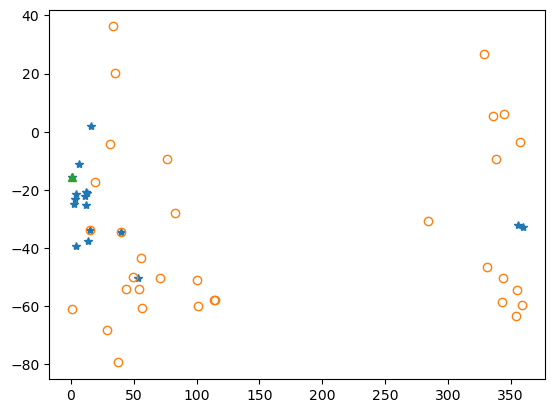

In [152]:
plt.plot(nbg_coords[nbgs_in_hlwas_south].ra,nbg_coords[nbgs_in_hlwas_south].dec,'*')
plt.plot(nbglm['ra'][nbglm_in_hlwas_south],nbglm['dec'][nbglm_in_hlwas_south],'o',mfc='none')
plt.plot(nbg_coords[56].ra,nbg_coords[56].dec,'^')

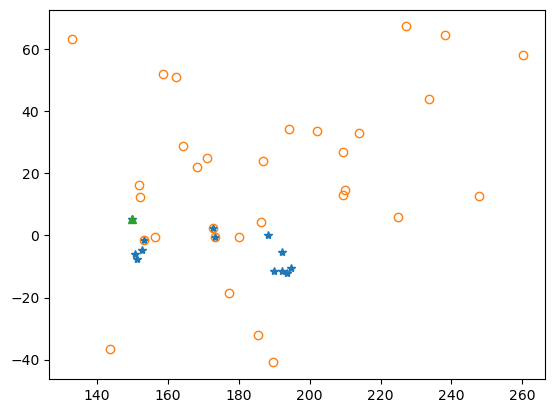

In [163]:
plt.plot(nbg_coords[nbgs_in_hlwas_north].ra,nbg_coords[nbgs_in_hlwas_north].dec,'*')
plt.plot(nbglm['ra'][nbglm_in_hlwas_north],nbglm['dec'][nbglm_in_hlwas_north],'o',mfc='none')
plt.plot(nbg_coords[60].ra,nbg_coords[60].dec,'^')

In [ ]:
plt.plot(

In [22]:
inorth = np.arange(1, len(nbgs_in_hlwas_north)+1).astype(str)
inorth

isouth = (np.arange(1,len(nbgs_in_hlwas_south)+1) + len(nbgs_in_hlwas_north)).astype(str)
inorth, isouth

(array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13'], dtype='<U21'),
 array(['14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
        '25', '26', '27', '28', '29', '30'], dtype='<U21'))

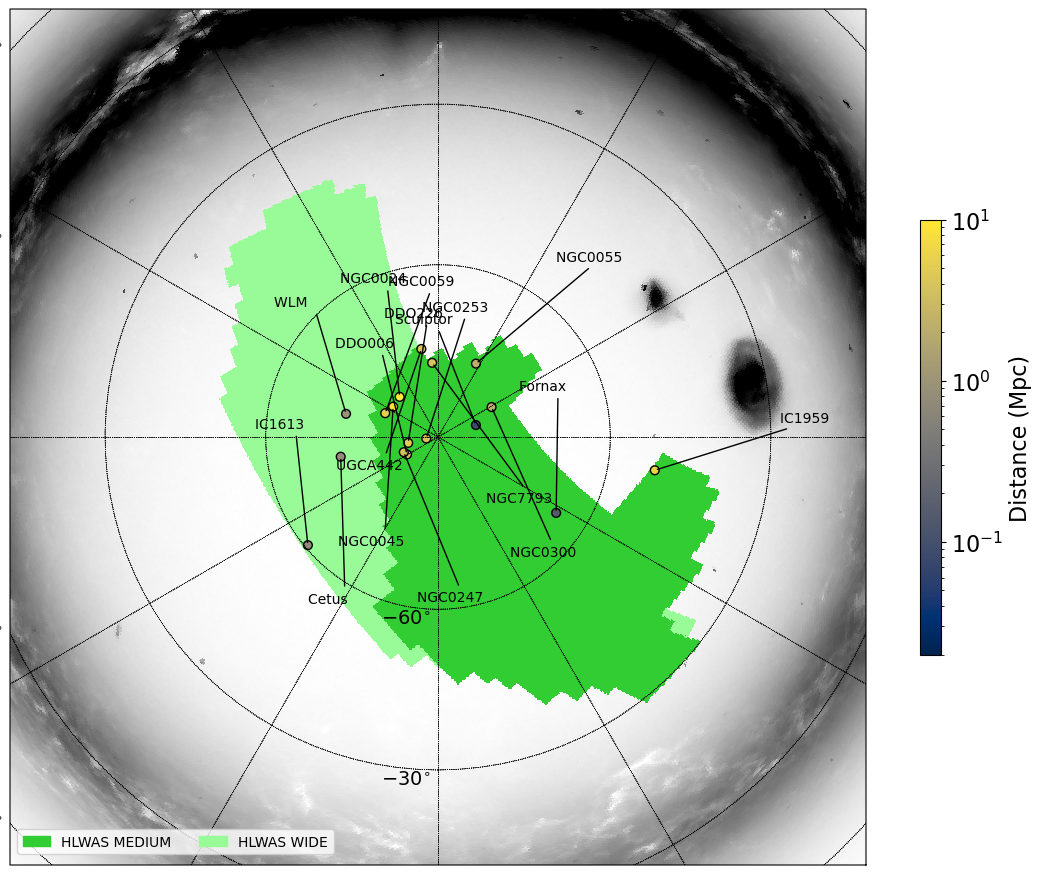

In [49]:
fig, ax = plt.subplots(figsize=(11,9))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(-90, -10))
im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
#sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
#sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
#sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
#sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
#sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')


#plot_streams(sp,mws,dist=False, streamlist = s_pole, annotate=True)
cbh = plot_galaxies(sp, glist=nbgs_in_hlwas_south,annotate=True,glabels=nbgs['Gal. Name    '][nbgs_in_hlwas_south])


# sp.draw_polygon([nbg_coords[nbgs_in_hlwas_south[2]].galactic.l.value,1.02*nbg_coords[nbgs_in_hlwas_south[2]].galactic.l.value],
#             [nbg_coords[nbgs_in_hlwas_south[2]].galactic.b.value,1.02*nbg_coords[nbgs_in_hlwas_south[2]].galactic.b.value],
#             edgecolor='k',facecolor=None,lw=2)
shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles)

sp.legend(handles=shandles, loc='upper left', ncol=2,  fontsize=10, bbox_to_anchor=(0.0,0.0, 1.0, 0.05))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
cb=plt.colorbar(cbh, shrink=0.5)
cb.set_label(label='Distance (Mpc)', size=16)
cb.ax.tick_params(labelsize=16)
plt.tight_layout(h_pad=0.1,w_pad=0.1)
#plt.savefig('../figures/ccs_footprints_nbgs_southpole.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_nbgs_southpole.png',dpi=300,bbox_inches='tight')
plt.show()

In [158]:
for i,sat in enumerate(nbg_coords):
    ipix = hp.ang2pix(hp.get_nside(combined_map),sat.galactic.l.value, sat.galactic.b.value,lonlat=True)
    if not combined_map[ipix]==hp.UNSEEN:
        nbgs_in_hlwas.append(i)
        which_s = labels[int(combined_map[ipix])-1][6:].lower()
        if sat.galactic.b.value > 0: 
            which_s += ' N'
        else:
            which_s += ' S'
        print(nbgs['Gal. Name    '][i], '&', nbgs['RA J2000  '][i],'&', nbgs['DEC J2000'][i] ,'&', nbgs['AbsBmag '][i],'&', nbgs[' D (Mpc)'][i] ,'&', nbgs[' Kmag '][i],'&', which_s, ' \\\\' )

Sculptor      & 01 00 09.4 & -33 42 33 & -9.8 & 0.09 & 5.9 & medium S  \\
SexDSph       & 10 13 03.0 & -01 36 52 & -8.7 & 0.09 & 7.01 & medium N  \\
Fornax        & 02 39 54.7 & -34 31 33 & -11.5 & 0.14 & 5.13 & medium S  \\
LeoIV         & 11 32 57.0 & -00 32 00 & -4.2 & 0.16 & 12.7 & wide N  \\
LeoV          & 11 31 09.6 & +02 13 12 & -3.8 & 0.18 & 13.39 & wide N  \\
IC1613        & 01 04 47.8 & +02 08 00 & -14.5 & 0.73 & 7.43 & wide S  \\
Cetus         & 00 26 11.0 & -11 02 40 & -10.2 & 0.78 & 10.19 & wide S  \\
WLM           & 00 01 58.1 & -15 27 40 & -14.1 & 0.97 & 9.0 & wide S  \\
SexA          & 10 11 00.8 & -04 41 34 & -13.9 & 1.32 & 10.18 & medium N  \\
SexB          & 10 00 00.1 & +05 19 56 & -14.0 & 1.36 & 9.5 & medium N  \\
NGC0055       & 00 15 08.5 & -39 13 13 & -18.4 & 2.13 & 6.25 & medium S  \\
NGC0300       & 00 54 53.5 & -37 40 57 & -17.9 & 2.15 & 6.38 & medium S  \\
DDO006        & 00 49 49.3 & -21 00 58 & -12.4 & 3.34 & 13.26 & medium S  \\
NGC0247       & 00 47 08.

In [159]:
nbgs_in_hlwas

[13,
 14,
 17,
 20,
 21,
 38,
 43,
 56,
 59,
 60,
 64,
 65,
 87,
 101,
 113,
 115,
 123,
 147,
 155,
 169,
 188,
 215,
 228,
 235,
 238,
 245,
 247,
 249,
 250,
 258]

In [ ]:
for i,sat in enumerate(nbg_coords[in_mw]):
    ipix = hp.ang2pix(hp.get_nside(combined_map),sat.galactic.l.value, sat.galactic.b.value,lonlat=True)
    if not combined_map[ipix]==hp.UNSEEN: print(nbgs[in_mw]['Gal. Name    '][i], combined_map[ipix])

In [131]:
combined_map[i3]

np.float64(-1.6375e+30)

### southern galactic cap with GCs

In [24]:
gcs=read_gcs()

In [66]:
near_hlwas_north_names = ['Pal 12','NGC 7099','NGC 7492','NGC 288', 'Whiting 1','Eridanus', 'E 1', 'Pal 13','NGC 1261','NGC 1904','NGC 1851','NGC 7089']

In [67]:
near_hlwas_north = np.array([np.where(gcs['Name']==n)[0][0] for n in in_hlwas_north_names])

In [68]:
gcs[near_hlwas_north]

<Table length=12>
   Name   OName RAJ2000 DEJ2000 ...  Rscale Nstar         SimbadName        
                  deg     deg   ...  arcmin                                 
  str12   str10 float32 float32 ... float32 int32           str26           
--------- ----- ------- ------- ... ------- ----- --------------------------
   Pal 12       326.662 -21.253 ...    0.95   185                     Pal 12
 NGC 7099  M 30 325.092 -23.180 ...    2.77  2990                   NGC 7099
 NGC 7492       347.111 -15.611 ...    1.13   190                   NGC 7492
  NGC 288        13.188 -26.583 ...    2.79  4689                    NGC 288
Whiting 1        30.737  -3.253 ...    0.52    40                  Whiting 1
 Eridanus        66.185 -21.187 ...    0.52    44 NAME Eridanus Star Cluster
      E 1  AM 1  58.760 -49.615 ...    0.36    58                        E 1
   Pal 13       346.685  12.772 ...    0.66    72                     Pal 13
 NGC 1261        48.068 -55.216 ...    1.73  1218                   NGC 1261
 NGC 1904  M 79  81.044 -24.524 ...    1.90  1556                   NGC 1904
 NGC 1851        78.528 -40.047 ...    2.59  2497                   NGC 1851
 NGC 7089   M 2 323.363  -0.823 ...    3.52  3091                   NGC 7089

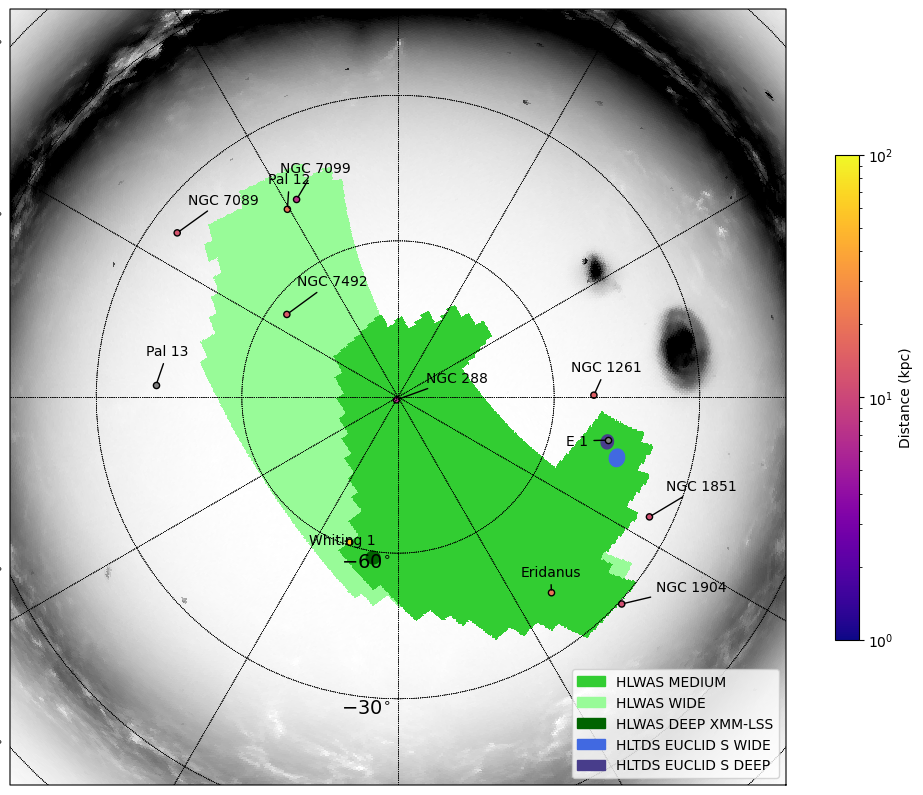

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=-90.0, galactic=True, extent=[0,360, -90,-10])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(-90, -10))
im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(-90, -10), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
#sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
#sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)

cbh=plot_gcs(sp,gcs, near_hlwas_north,annotate=True)


patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')


shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles[:3])

sp.legend(handles=shandles, loc='lower right', ncol=1,  fontsize=10)#, bbox_to_anchor=(1.0,0.0, 0.05, 1.0))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
plt.tight_layout()
plt.colorbar(cbh,label='Distance (kpc)', shrink=0.5)
plt.savefig('../figures/ccs_footprints_gcs_southpole.png',dpi=200,bbox_inches='tight')
plt.show()

### northern galactic cap with streams

In [62]:
ids_in_north = [99,31,55,9,101,28,140,127,113,111,128,141,109,38,133,84,37,41,32,42,119,27,62,42,83,80,50,43]
set(ids_in_north).intersection(set(id_in_hlwas))

{99}

In [63]:
len(ids_in_north)

28

In [64]:
in_hlwas_north = []
for st in mws.keys():
    if mws[st].ID in ids_in_north:
        in_hlwas_north.append(st)

In [65]:
#select streams that cross the northern hlwas fields
n_pole = mws.get_track_names_in_sky_window([220,330]*u.deg, [15,60]*u.deg, frame=astropy.coordinates.Galactic)

In [55]:
#select the stream that goes across the elais field
elais = mws.get_track_names_in_sky_window([(elais_n1.galactic.l.value - 2.), (elais_n1.galactic.l.value+2.)]*u.deg, 
                                          [elais_n1.galactic.b.value - 2., elais_n1.galactic.b.value + 2.]*u.deg,
                                          frame=astropy.coordinates.Galactic)

In [56]:
#select the stream that goes across the northern deep field
cosmos = mws.get_track_names_in_sky_window([(hlwas_cosmos.galactic.l.value - 2.), (hlwas_cosmos.galactic.l.value+2.)]*u.deg, 
                                          [hlwas_cosmos.galactic.b.value - 2., hlwas_cosmos.galactic.b.value + 2.]*u.deg,
                                          frame=astropy.coordinates.Galactic)

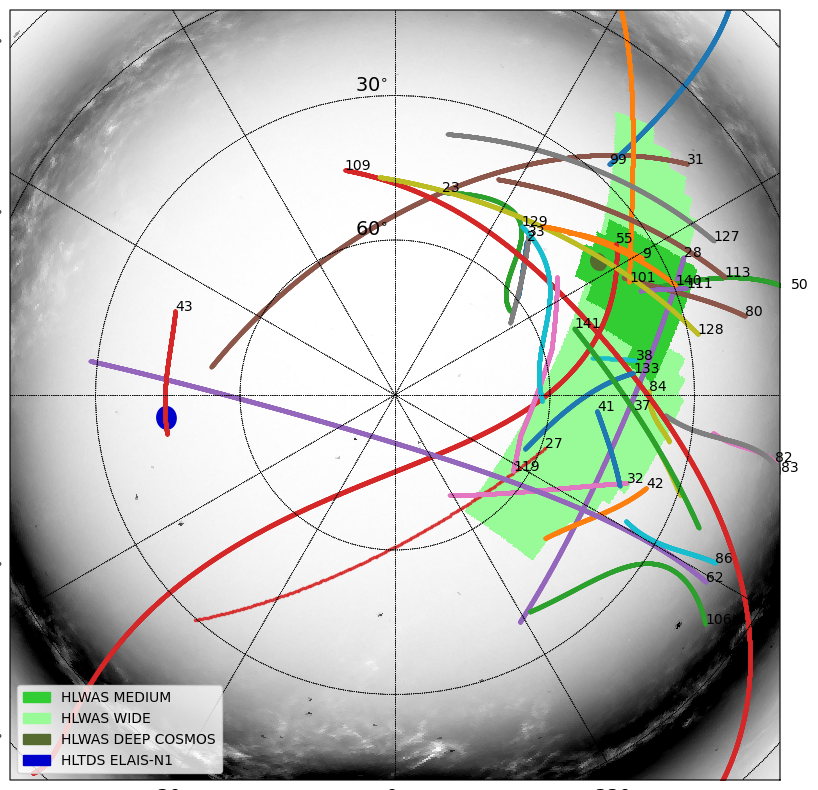

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(10,90))

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(10,90), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
#sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
#sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
#sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)

#plot_streams(sp,mws,dist=False,streamlist=in_hlwas_north, annotate=True)
plot_streams(sp,mws,dist=False,streamlist=n_pole, annotate=True)
plot_streams(sp,mws,dist=False,streamlist=elais, annotate=True)

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles[:2])


sp.legend(handles=shandles, loc='lower left', ncol=1,  fontsize=10)#, bbox_to_anchor=(1.0,0.05, 0.05, 1.0))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
#plt.savefig('../figures/ccs_footprints_streams_northpole.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_streams_northpole_all.png',dpi=200,bbox_inches='tight')
plt.show()

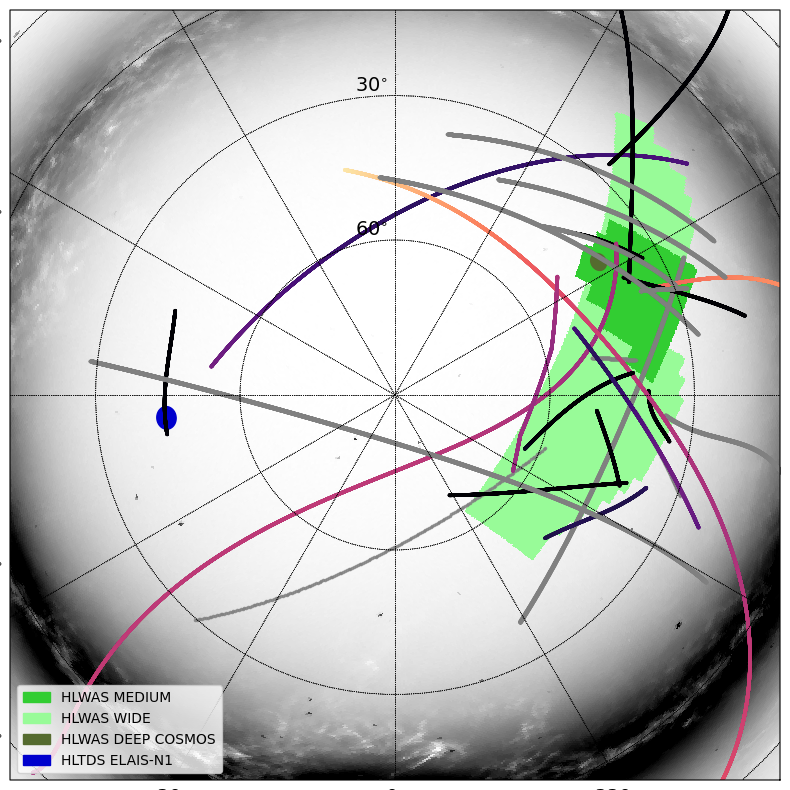

In [69]:
fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(10,90))

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(10,90), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
#sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
#sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
#sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)

#plot_streams(sp,mws,dist=False,streamlist=in_hlwas_north, annotate=True)
cbh=plot_streams(sp,mws,dist=True, streamlist = in_hlwas_north, annotate=False)

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles[:2])


sp.legend(handles=shandles, loc='lower left', ncol=1,  fontsize=10)#, bbox_to_anchor=(1.0,0.05, 0.05, 1.0))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)


#plt.savefig('../figures/ccs_footprints_streams_northpole.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/ccs_footprints_streams_northpole_distances.png',dpi=300)
plt.show()

In [37]:
for st in in_hlwas_north:
    if not mws.summary.has_D[st]:
        if not mws.summary.has_pm[st]:
            print(mws[st].ID, " & ", mws[st].stream_name, " & & & \\citet{" + mws.summary.TrackRefsLatex[st]+ "} \\\\")
        else:
            print(mws[st].ID, " & ", mws[st].stream_name, " &    & *  & \\citet{" + mws.summary.TrackRefsLatex[st]+ "} \\\\")
            
    if mws.summary.has_D[st]:
        if not mws.summary.has_pm[st]:
            print(mws[st].ID, " & ", mws[st].stream_name, " &  *  &  &\\citet{" + mws.summary.TrackRefsLatex[st]+ "} \\\\")
        else:
            print(mws[st].ID, " & ", mws[st].stream_name, " &  *  & * & \\citet{" + mws.summary.TrackRefsLatex[st]+ "} \\\\")

9  &  C-10  &  *  & * & \citet{Ibata2024} \\
27  &  Cocytos  & & & \citet{Grillmair2009} \\
28  &  Corvus  & & & \citet{Mateu2018} \\
31  &  GD-1  &  *  & * & \citet{Ibata2021} \\
32  &  Gaia-1  &  *  & * & \citet{Ibata2021} \\
37  &  Gaia-3  & & & \citet{Malhan2018} \\
38  &  Gaia-4  & & & \citet{Malhan2018} \\
41  &  Gaia-7  &  *  & * & \citet{Ibata2021} \\
42  &  Gaia-8  &  *  & * & \citet{Ibata2021} \\
43  &  Gaia-9  &  *  & * & \citet{Ibata2021} \\
50  &  Jet  &  *  & * & \citet{Ferguson2022} \\
55  &  LMS-1  &  *  & * & \citet{Yuan2020} \\
62  &  M68-Fjorm  &  *  & * & \citet{Palau2019} \\
80  &  New-10  &  *  & * & \citet{Ibata2024} \\
83  &  New-13  &    & *  & \citet{Ibata2024} \\
84  &  New-14  &  *  & * & \citet{Ibata2024} \\
99  &  New-3  &  *  & * & \citet{Ibata2024} \\
101  &  New-5  &  *  & * & \citet{Ibata2024} \\
109  &  Orphan-Chenab  &  *  & * & \citet{Koposov2023} \\
111  &  PS1-B  & & & \citet{Bernard2016} \\
113  &  PS1-D  & & & \citet{Bernard2016} \\
119  &  Para

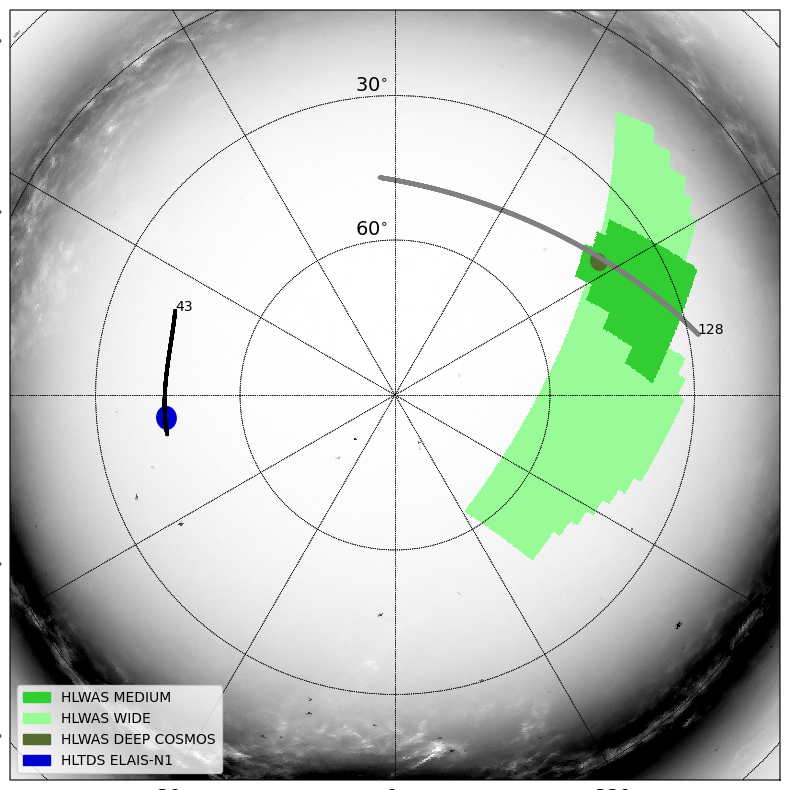

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(10,90))

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(10,90), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
#sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
#sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
#sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)

#plot_streams(sp,mws,dist=False,streamlist=in_hlwas_north, annotate=True)
cbh=plot_streams(sp,mws,dist=True, streamlist = elais, annotate=True)
cbh=plot_streams(sp,mws,dist=True, streamlist = cosmos, annotate=True)

patch_HLWAS_w = mpatches.Patch(color=col_dict[1], label='HLWAS WIDE')
patch_HLWAS_m = mpatches.Patch(color=col_dict[2], label='HLWAS MEDIUM')
shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles[:2])


sp.legend(handles=shandles, loc='lower left', ncol=1,  fontsize=10)#, bbox_to_anchor=(1.0,0.05, 0.05, 1.0))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)


#plt.savefig('../figures/ccs_footprints_streams_northpole.pdf',dpi=600,bbox_inches='tight')
plt.savefig('../figures/deep_streams_northpole_distances.png',dpi=300)
plt.show()

### northern galactic cap with nearby galaxies

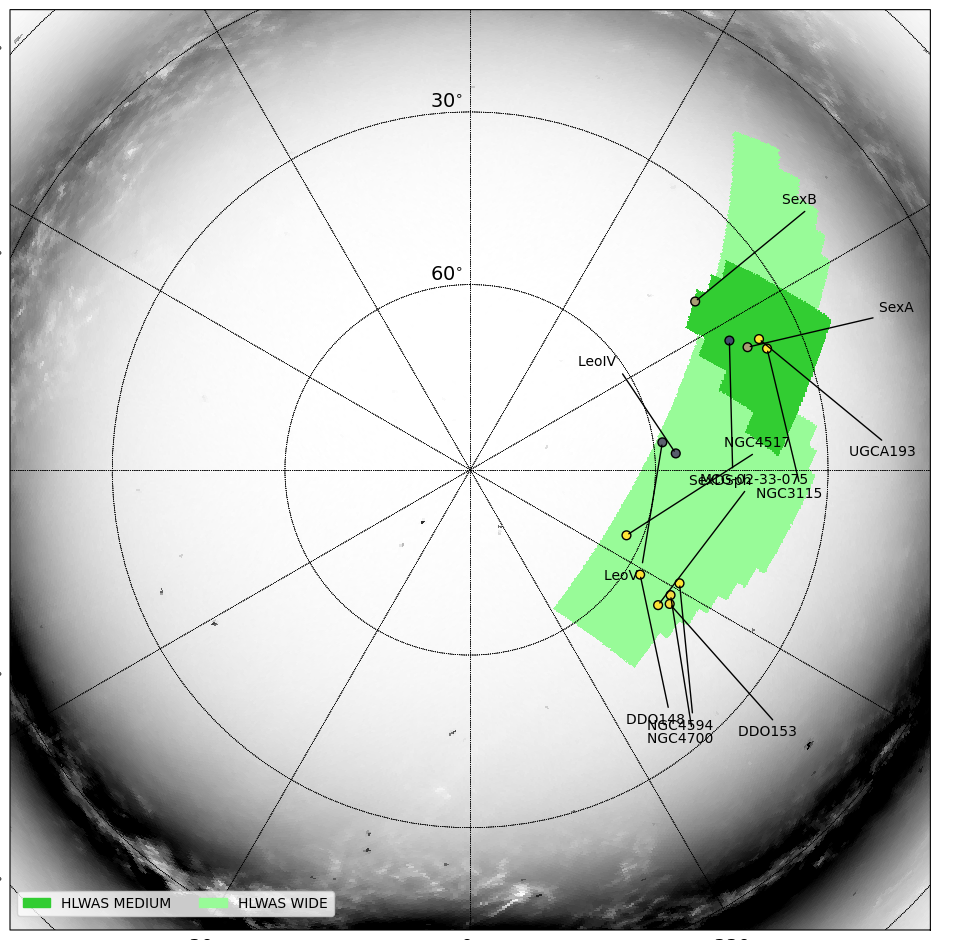

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.LaeaSkyproj(ax=ax, lat_0=90.0, galactic=True, extent=[0,360, 10,90])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=(0,360), lat_range=(10,90))

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=(0,360), lat_range=(10,90), alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
#sp.circle(hlwas_cosmos.galactic.l.value, hlwas_cosmos.galactic.b.value, 3.1/2, label='HLWAS DEEP COSMOS', alpha=alph, fill=True, color='darkolivegreen')
#sp.circle(hlwas_xmm.galactic.l.value, hlwas_xmm.galactic.b.value, 2.5/2, label='HLWAS DEEP XMM-LSS', alpha=alph, color='darkgreen', fill=True)
#sp.circle(elais_n1.galactic.l.value, elais_n1.galactic.b.value, 4./2, label='HLTDS ELAIS-N1', fill=True, alpha=alph, color='mediumblue')
#sp.circle(euclid_s_wide.galactic.l.value, euclid_s_wide.galactic.b.value, 3.1/2, label='HLTDS EUCLID S WIDE', alpha=alph, fill=True, color='royalblue')
#sp.circle(euclid_s_deep.galactic.l.value, euclid_s_deep.galactic.b.value, 2.5/2, label='HLTDS EUCLID S DEEP', alpha=alph, color='darkslateblue', fill=True)


#plot_streams(sp,mws,dist=False, streamlist = s_pole, annotate=True)
cbh = plot_galaxies(sp, glist=nbgs_in_hlwas_north,annotate=True,glabels=nbgs['Gal. Name    '][nbgs_in_hlwas_north])


shandles=[patch_HLWAS_m,patch_HLWAS_w]
handles, labels = sp.ax.get_legend_handles_labels()
shandles.extend(handles)

sp.legend(handles=shandles, loc='upper left', ncol=2,  fontsize=10, bbox_to_anchor=(0.0,0.0, 1.0, 0.05))

sp.ax.tick_params(axis="x", labelsize=14)
sp.ax.tick_params(axis="y", labelsize=14)
#cb=plt.colorbar(cbh, shrink=0.5)
#cb.set_label(label='Distance (Mpc)', size=16)
#cb.ax.tick_params(labelsize=16)
plt.tight_layout(h_pad=0.1,w_pad=0.1)
plt.savefig('../figures/ccs_footprints_nbgs_northpole.png',dpi=300,bbox_inches='tight')
plt.show()

In [124]:
astropy.coordinates.Galactocentric()

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

In [125]:
astropy.coordinates.SkyCoord?

Init signature: astropy.coordinates.SkyCoord(*args, copy=True, **kwargs)
Docstring:     
High-level object providing a flexible interface for celestial coordinate
representation, manipulation, and transformation between systems.

The |SkyCoord| class accepts a wide variety of inputs for initialization. At
a minimum these must provide one or more celestial coordinate values with
unambiguous units.  Inputs may be scalars or lists/tuples/arrays, yielding
scalar or array coordinates (can be checked via ``SkyCoord.isscalar``).
Typically one also specifies the coordinate frame, though this is not
required. The general pattern for spherical representations is::

  SkyCoord(COORD, [FRAME], keyword_args ...)
  SkyCoord(LON, LAT, [FRAME], keyword_args ...)
  SkyCoord(LON, LAT, [DISTANCE], frame=FRAME, unit=UNIT, keyword_args ...)
  SkyCoord([FRAME], <lon_attr>=LON, <lat_attr>=LAT, keyword_args ...)

It is also possible to input coordinate values in other representations
such as cartesian or cyli

In [141]:
cloud1=astropy.coordinates.SkyCoord(l=165*u.deg,b=-32*u.deg, distance=40*u.pc, frame=astropy.coordinates.Galactic)
cloud2=astropy.coordinates.SkyCoord(l=27*u.deg,b=-31*u.deg, distance=45*u.pc, frame=astropy.coordinates.Galactic)
cloud3=astropy.coordinates.SkyCoord(l=329*u.deg,b=46*u.deg, distance=65*u.pc, frame=astropy.coordinates.Galactic)

In [134]:
cloud1.galactocentric.z

<Quantity -0.31282306 pc>

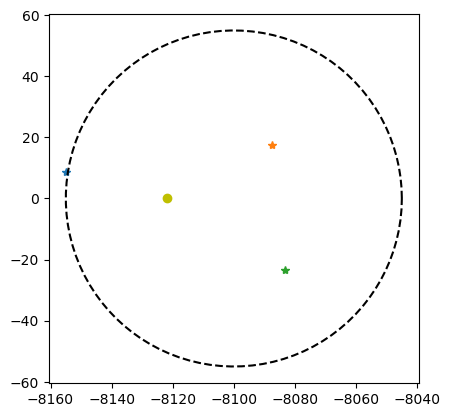

In [153]:
plt.plot(cloud1.galactocentric.x, cloud1.galactocentric.y,'*')
plt.plot(cloud2.galactocentric.x, cloud2.galactocentric.y,'*')
plt.plot(cloud3.galactocentric.x, cloud3.galactocentric.y,'*')
plt.plot(-8.122e3,0,'oy')
xb=-8.1e3
yb=0
plt.plot(55*np.cos(np.linspace(0,2*np.pi,100))+xb,55*np.sin(np.linspace(0,2*np.pi,100))+yb,'--k')
plt.gca().set_aspect('equal')

In [ ]:
plt.plot(cloud1.galactocentric.x, cloud1.galactocentric.y,'.')